# Lanczos Filter

此程式碼根據 https://github.com/liv0505/Lanczos-Filter 以及NCL的bandpass filter、`filwgts_lanczos`進行修改 (感謝台大大氣系廖建泓協助更新)。

首先建立自訂義函式：

In [1]:
#-------------------------filter function-------------------------------------------------#
def low_pass_weights(nwts, cutoff):

    import numpy as np

    """Calculate weights for a low pass Lanczos filter.
    Args:
    nwts: int  (Source: NCL)
        A scalar indicating the total number of weights (must be an odd number; nwt >= 3). 
        The more weights, the better the filter, but there is a greater loss of data.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

def high_pass_weights(nwts, cutoff):

    import numpy as np

    """Calculate weights for a high pass Lanczos filter.
    Args:
    nwts: int  (Source: NCL)
        A scalar indicating the total number of weights (must be an odd number; nwt >= 3). 
        The more weights, the better the filter, but there is a greater loss of data.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 1 - 2 * cutoff            #w0
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = -firstfactor * sigma
    w[n+1:-1] = -firstfactor * sigma
    return w[1:-1]

def lanczos_hp_filter(data,nwts,fca,srate): 
    """" 
    Args: 
    nwts: int  (Source: NCL)
        A scalar indicating the total number of weights (must be an odd number; nwt >= 3). 
        The more weights, the better the filter, but there is a greater loss of data.

    fca: float
        A scalar indicating the cut-off frequency of the ideal high or low-pass filter: (0.0 < fca < 0.5).

    """

    import xarray as xr 
    # construct 3 days and 10 days low pass filters
    hfw = high_pass_weights(nwts, fca*(1/srate))
    weight_high  = xr.DataArray(hfw, dims = ['window'])

    # apply the filters using the rolling method with the weights
    highpass_hf = data.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)

    # the bandpass is the difference of two lowpass filters.
    highpass = highpass_hf

    return highpass 

def lanczos_lp_filter(data,nwts,fca,srate): 
    """" 
    Args: 
    nwts: int  (Source: NCL)
        A scalar indicating the total number of weights (must be an odd number; nwt >= 3). 
        The more weights, the better the filter, but there is a greater loss of data.

    fca: float
        A scalar indicating the cut-off frequency of the ideal low-pass filter: (0.0 < fca < 0.5).
    """

    import xarray as xr 
    # construct 3 days and 10 days low pass filters
    lfw = low_pass_weights(nwts, fca*(1/srate))
    weight_low  = xr.DataArray(lfw, dims = ['window'])

    # apply the filters using the rolling method with the weights
    lowpass_lf = data.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

    # the bandpass is the difference of two lowpass filters.
    lowpass = lowpass_lf

    return lowpass 

def lanczos_bp_filter(data,nwts,fca,fcb,srate): 
    """" 
    Args: 
    nwts: int  (Source: NCL)
        A scalar indicating the total number of weights (must be an odd number; nwt >= 3). 
        The more weights, the better the filter, but there is a greater loss of data.

    fca: float
        A scalar indicating the cut-off frequency of the ideal high or low-pass filter: (0.0 < fca < 0.5).

    fcb: float
        A scalar used only when a band-pass filter is desired. It is the second cut-off frequency (fca < fcb < 0.5).
    """

    import xarray as xr 
    # construct 3 days and 10 days low pass filters
    hfw = low_pass_weights(nwts, fcb*(1/srate))
    lfw = low_pass_weights(nwts, fca*(1/srate))
    weight_high = xr.DataArray(hfw, dims = ['window'])
    weight_low  = xr.DataArray(lfw, dims = ['window'])

    # apply the filters using the rolling method with the weights
    lowpass_hf = data.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
    lowpass_lf = data.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

    # the bandpass is the difference of two lowpass filters.
    bandpass = lowpass_hf - lowpass_lf

    return bandpass 

接著我們只需要引用 `lanczos_hp_filter`、`lanczos_lp_filter`、`lanczos_bp_filter`函數，就可以分別計算高通、低通和帶通濾波。這個函式需要提供幾個引數：
- `data`: 資料的DataArray。
- `nwts`: 帶通濾波的權重 (weights)，必須滿足 `nwts` $\ge $ 3。數值越大時，濾波效果越好，但也會有越多資料損失 (NaN)。一般而言，對於Lanczos的濾波，`nwts=201`。
- `fca`, `fcb`: 帶通濾波的兩個截止頻率，必須滿足 0 < `fca` < `fcb` < 0.5。(如果是高通和低通濾波，只需要考慮`fca`)
- `srate`: 資料的時間解析度，即一天有幾個資料點。

**Example 1:** 計算冬季 (DJF) OLR在10天以下、10-30天、30-60天、120天以上的variance佔total variance的比例。

In [2]:
import xarray as xr 
import numpy as np 
import cmaps
import matplotlib as mpl
from matplotlib import pyplot as plt
from cartopy import crs as ccrs   
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
mpl.rcParams['figure.dpi'] = 200

olr = (xr.open_dataset('data/olr.nc')
         .sel(lat=slice(-20,30),lon=slice(40,180)).olr) 

/Users/waynetsai/.local/lib/python3.10/site-packages/ecmwflibs/__init__.py:83: UserWarning: dlopen(/Users/waynetsai/.local/lib/python3.10/site-packages/ecmwflibs/_ecmwflibs.cpython-310-darwin.so, 0x0002): tried: '/Users/waynetsai/.local/lib/python3.10/site-packages/ecmwflibs/_ecmwflibs.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/waynetsai/.local/lib/python3.10/site-packages/ecmwflibs/_ecmwflibs.cpython-310-darwin.so' (no such file), '/Users/waynetsai/.local/lib/python3.10/site-packages/ecmwflibs/_ecmwflibs.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))
  warnings.warn(str(e))


In [3]:
# 將OLR送進濾波函數
olr_10_hp    = lanczos_hp_filter(data=olr, nwts=201,fca=(1./10.)             ,srate=1)
olr_30_60_bp = lanczos_bp_filter(data=olr, nwts=201,fca=(1./60.),fcb=(1./30.),srate=1)
olr_10_30_bp = lanczos_bp_filter(data=olr, nwts=201,fca=(1./20.),fcb=(1./10.),srate=1)
olr_120_lp   = lanczos_lp_filter(data=olr, nwts=201,fca=(1./120.)            ,srate=1)

In [4]:
olr_djf = olr.sel(time=olr.time.dt.month.isin([1,2,12]))

# 計算各波段變異量相對於總變異量的比例
olr_10_hp_djf = olr_10_hp.sel(time=olr_10_hp.time.dt.month.isin([1,2,12]))
djf_10hp_var_rt = ( olr_10_hp_djf.sel(time=slice('1999-01-01','2020-12-31')).var(axis=0) / 
                          olr_djf.sel(time=slice('1999-01-01','2020-12-31')).var(axis=0)) 

olr_30_60_bp_djf = olr_30_60_bp.sel(time=olr_30_60_bp.time.dt.month.isin([1,2,12]))
djf_30_60_var_rt = ( olr_30_60_bp_djf.sel(time=slice('1999-01-01','2020-12-31')).var(axis=0) / 
                              olr_djf.sel(time=slice('1999-01-01','2020-12-31')).var(axis=0)) 

olr_10_30_bp_djf = olr_10_30_bp.sel(time=olr_10_30_bp.time.dt.month.isin([1,2,12]))
djf_10_30_var_rt = ( olr_10_30_bp_djf.sel(time=slice('1999-01-01','2020-12-31')).var(axis=0) / 
                              olr_djf.sel(time=slice('1999-01-01','2020-12-31')).var(axis=0)) 

olr_120_lp_djf = olr_120_lp.sel(time=olr_120_lp.time.dt.month.isin([1,2,12]))
djf_120lp_var_rt = ( olr_120_lp_djf.sel(time=slice('1999-01-01','2020-12-31')).var(axis=0) / 
                            olr_djf.sel(time=slice('1999-01-01','2020-12-31')).var(axis=0)) 

/Users/waynetsai/micromamba/envs/p3/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


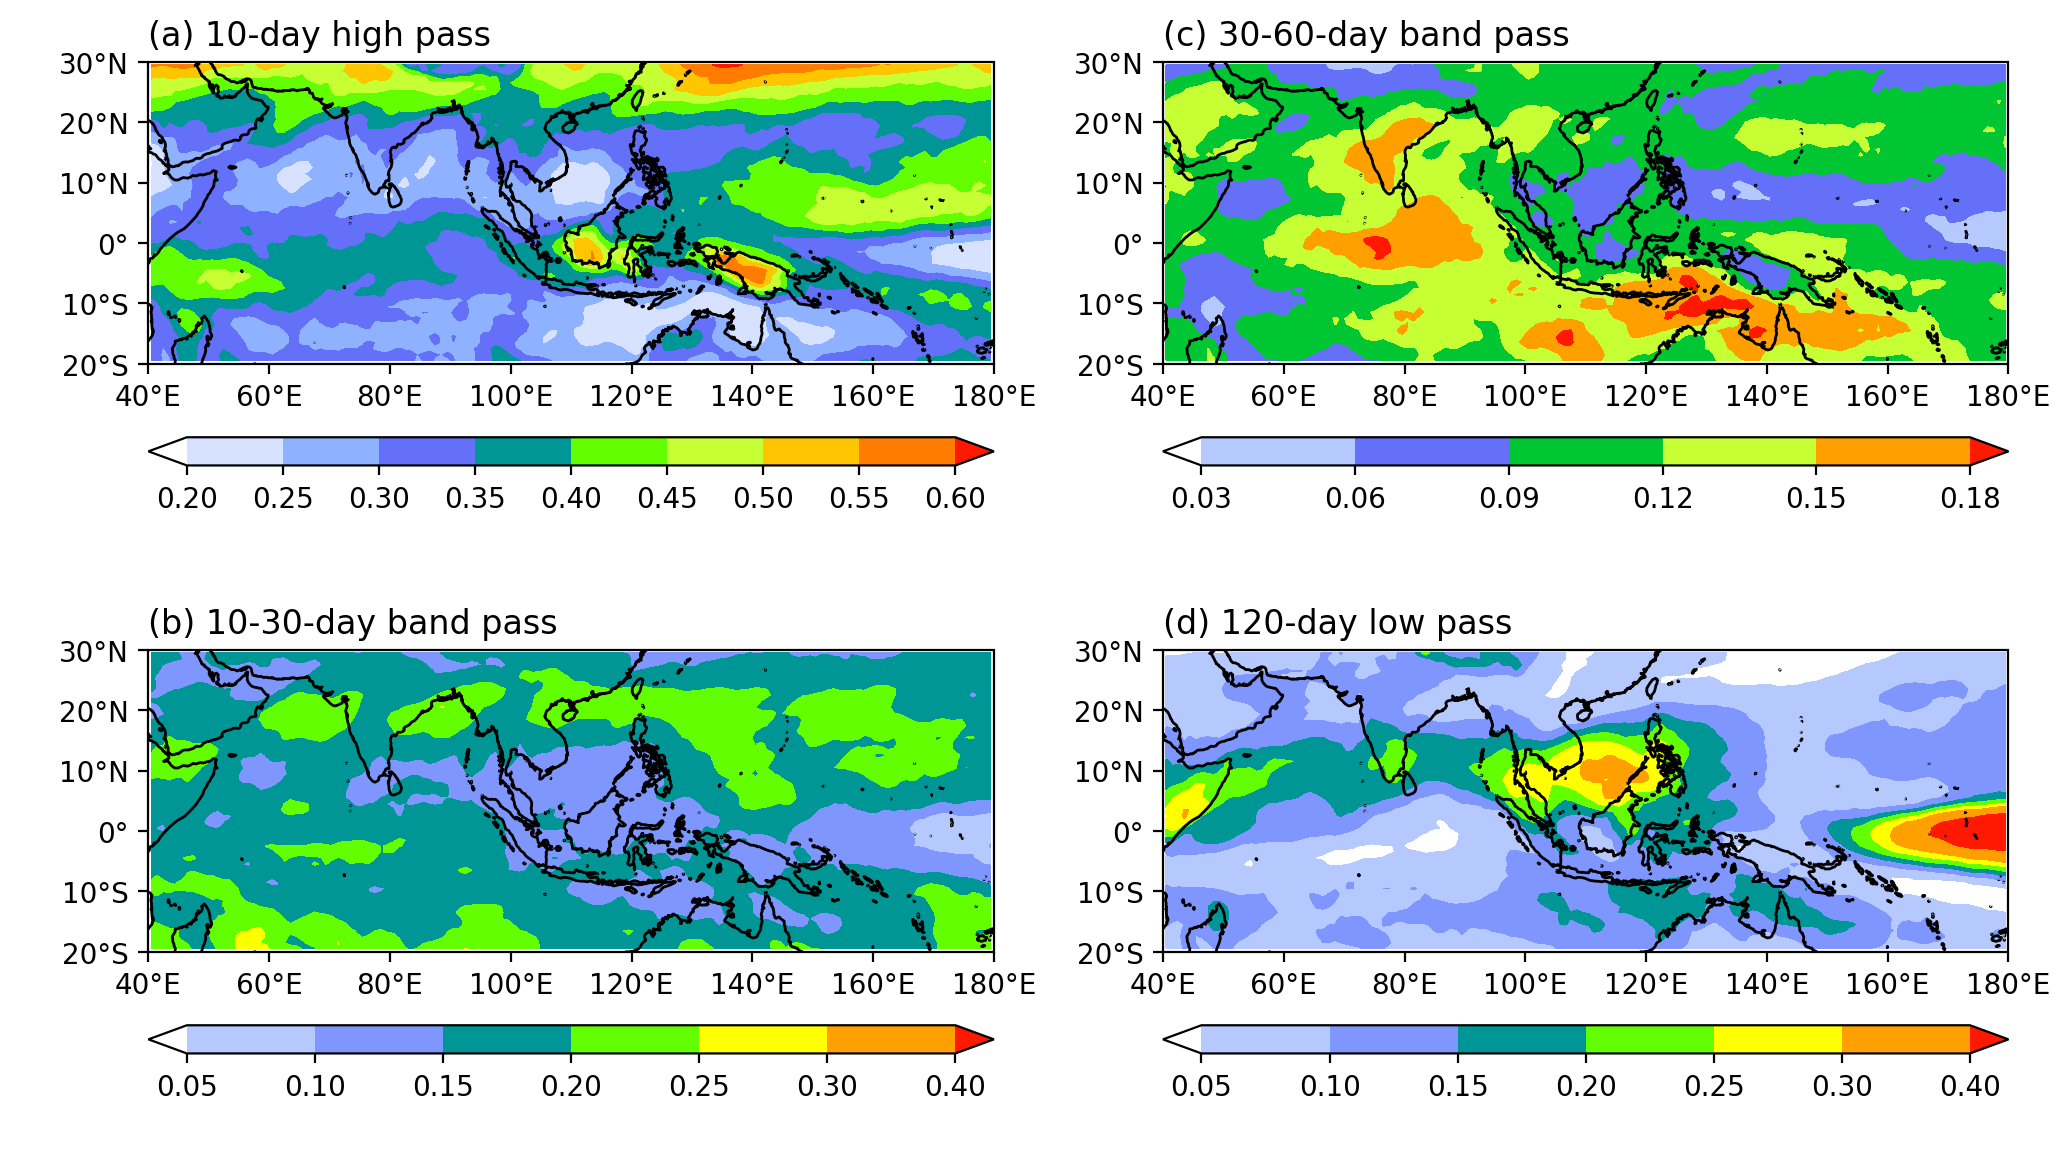

In [10]:
proj = ccrs.PlateCarree()     
fig,axes = plt.subplots(2,2,figsize=(12,7),subplot_kw={'projection':proj})   
ax = axes.flatten()

# 繪圖
cmap = cmaps.precip3_16lev
cf_10d_hp = djf_10hp_var_rt.plot.contourf("lon","lat",  
                                            transform=proj,     
                                            ax=ax[0],              
                                            levels=np.arange(0.2,0.65,0.05),   
                                            cmap=cmap,   
                                            add_colorbar=True, 
                                            extend='both',
                                            cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' '} 
                                            )
ax[0].set_title(' ')
ax[0].set_title('(a) 10-day high pass',loc='left')
cf_10_30d = djf_10_30_var_rt.plot.contourf("lon","lat",  
                                            transform=proj,     
                                            ax=ax[2],              
                                            levels=[0.05,0.1,0.15,0.2,0.25,0.3,0.4],   
                                            cmap=cmap,   
                                            add_colorbar=True, 
                                            extend='both',
                                            cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' '} 
                                            )
ax[2].set_title(' ')
ax[2].set_title('(b) 10-30-day band pass',loc='left')
cf_30_60d = djf_30_60_var_rt.plot.contourf("lon","lat",  
                                            transform=proj,   
                                            ax=ax[1],         
                                            levels=np.arange(0.03,0.21,0.03),
                                            cmap=cmap,   
                                            add_colorbar=True, 
                                            extend='both',
                                            cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' '}  
                                            )
ax[1].set_title(' ')
ax[1].set_title('(c) 30-60-day band pass',loc='left')
cf_120d_lp = djf_120lp_var_rt.plot.contourf("lon","lat",  
                                            transform=proj,     
                                            ax=ax[3],              
                                            levels=[0.05,0.1,0.15,0.2,0.25,0.3,0.4],   
                                            cmap=cmap,   
                                            add_colorbar=True, 
                                            extend='both',
                                            cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' '} 
                                            )
ax[3].set_title(' ')
ax[3].set_title('(d) 120-day low pass',loc='left')

lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER  
for i in range(0,4):
    ax[i].set_title('')
    ax[i].set_extent([40,180,-20,30],crs=proj)
    ax[i].set_xticks(np.arange(40,200,20), crs=proj)
    ax[i].set_yticks(np.arange(-20,40,10), crs=proj)   
    ax[i].xaxis.set_major_formatter(lon_formatter)
    ax[i].yaxis.set_major_formatter(lat_formatter) 
    ax[i].coastlines()                                    
    ax[i].set_ylabel(' ')   
    ax[i].set_xlabel(' ')

plt.show()